<a href="https://colab.research.google.com/github/KARENCMP82/Python/blob/main/1_clasificacion_viviendas_basico.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Nuestro cliente nos pregunta cuales son las viviendas que se van a vender de las que aún no se han vendido.  
Para ello, nos dan los datos de las viviendas que tienen en su base de datos.**

# Imports

Librerias

In [ ]:
# gestión de datos
import numpy as np
import pandas as pd

# gráficos
import seaborn as sns
import matplotlib.pyplot as plt

# preprocessing
from sklearn.preprocessing import StandardScaler

# modelos
from xgboost import XGBClassifier

# quitar alertas
import warnings
warnings.filterwarnings("ignore")

Datos

In [ ]:
# conexion a drive
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# carga de los datos en un dataframe
df = pd.read_csv('/content/drive/MyDrive/TIC/Data science/Master Data Science Nuclio - profesor/Aprendizaje supervisado - Clases/1.viviendas_basico.csv')

# Business Understanding​

In [ ]:
df

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,precio,vendida
0,viv_1,65.0,1,7,1991-01-01,ext,166000,1.0
1,viv_2,97.0,4,8,1994-01-01,ext,279000,1.0
2,viv_3,80.0,4,4,1970-01-01,sin,233000,1.0
3,viv_4,73.0,1,1,1983-01-01,ext,182000,1.0
4,viv_5,86.0,2,8,1999-01-01,sin,210000,1.0
...,...,...,...,...,...,...,...,...
6995,viv_6996,98.0,2,2,2006-01-01,int,342000,0.0
6996,viv_6997,111.0,4,2,1981-01-01,ext,121000,0.0
6997,viv_6998,76.0,3,4,2009-01-01,ext,250000,0.0
6998,viv_6999,128.0,3,5,1979-01-01,sin,317000,0.0


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7000 entries, 0 to 6999
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   id_vivienda  7000 non-null   object 
 1   superficie   6990 non-null   float64
 2   num_hab      7000 non-null   int64  
 3   distancia    7000 non-null   int64  
 4   fecha_const  7000 non-null   object 
 5   parking      7000 non-null   object 
 6   precio       7000 non-null   int64  
 7   vendida      7000 non-null   float64
dtypes: float64(2), int64(3), object(3)
memory usage: 437.6+ KB


Vamos a entrenar sobre todo el dataset, tanto con las viviendas que no se han vendido como con las viviendas que sí.  
El modelo necesita aprender como son las viviendas que se venden tanto como como son las que no se venden para poder clasificarlas.  
Haremos la predicción sobre las viviendas que aún no se han vendido.

In [ ]:
df_entrenar= df.copy()
df_predecir = df[df['vendida']==0]

In [ ]:
len(df_entrenar)

7000

In [ ]:
len(df_predecir)

2000

tenemos 7.000 viviendas que se han vendido para entrenar y 2.000 viviendas de las cuales queremos predecir si se van a vender.

Para el dataset a predecir, le quitamos la variable vendida por ser justamente lo que queremos predecir.

In [ ]:
target = 'vendida'
df_predecir.drop(target, inplace=True, axis=1)

In [ ]:
df_entrenar.nunique()

,0
id_vivienda,7000
superficie,71
num_hab,4
distancia,10
fecha_const,60
parking,3
precio,241
vendida,2


# Preprocessing

## data cleaning

In [ ]:
# comprobamos duplicados
df_entrenar.duplicated().sum()

0

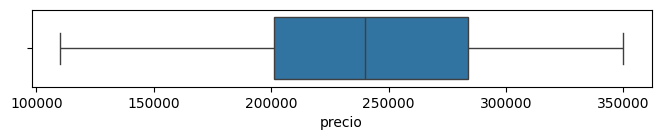

In [ ]:
# comprobamos outliers
fig, ax = plt.subplots(figsize=(8, 1))
sns.boxplot(data=df_entrenar, x='precio')
plt.show()

No apreciamos outlier en el precio.

## gestión de los nulos

In [ ]:
df_entrenar.isnull().sum()

,0
id_vivienda,0
superficie,10
num_hab,0
distancia,0
fecha_const,0
parking,0
precio,0
vendida,0


Eliminamos los 10 nulos

In [ ]:
df_entrenar = df_entrenar.dropna()

In [ ]:
df_predecir.isnull().sum()

,0
id_vivienda,0
superficie,0
num_hab,0
distancia,0
fecha_const,0
parking,0
precio,0


## gestión de las variables categóricas

### parking

In [ ]:
df_entrenar['parking'].unique()

array(['ext', 'sin', 'int'], dtype=object)

In [ ]:
df_entrenar['parking'].value_counts()

,count
parking,
ext,2402
int,2351
sin,2237


trataremos la variable parking con one hot encoding, creando una columna booleana por cada una de la categorias

### fecha_const

vamos a cambiar la fecha de contrucción por el año de construcción

In [ ]:
df_entrenar['fecha_const'] = pd.to_datetime(df_entrenar['fecha_const'])
df_entrenar['fecha_const'] = df_entrenar['fecha_const'].dt.year

df_predecir['fecha_const'] = pd.to_datetime(df_predecir['fecha_const'])
df_predecir['fecha_const'] = df_predecir['fecha_const'].dt.year

In [ ]:
df_entrenar

,id_vivienda,superficie,num_hab,distancia,fecha_const,parking,precio,vendida
0,viv_1,65.0,1,7,1991,ext,166000,1.0
1,viv_2,97.0,4,8,1994,ext,279000,1.0
2,viv_3,80.0,4,4,1970,sin,233000,1.0
3,viv_4,73.0,1,1,1983,ext,182000,1.0
4,viv_5,86.0,2,8,1999,sin,210000,1.0
...,...,...,...,...,...,...,...,...
6995,viv_6996,98.0,2,2,2006,int,342000,0.0
6996,viv_6997,111.0,4,2,1981,ext,121000,0.0
6997,viv_6998,76.0,3,4,2009,ext,250000,0.0
6998,viv_6999,128.0,3,5,1979,sin,317000,0.0


### id_vivienda

eliminamos el id_vivienda por ser único y no aportar para generalizar una regla para definir el precio de la vivienda: el precio no depende del id de la vivienda.

In [ ]:
df_entrenar.drop(['id_vivienda'], inplace=True, axis=1)

para el dataset a predecir, conservamos el id de las viviendas en una lista para entregar posteriormente un archivo con el id de la vivienda y su precio predicho.  
ojo: a partir de este momento no podemos quitar observaciones ni cambiar el orden de las viviendas del dataset a predecir

In [ ]:
id_viviendas_predecir = df_predecir['id_vivienda']
df_predecir.drop(['id_vivienda'], inplace=True, axis=1)

## one hot encoding

In [ ]:
df_entrenar = pd.get_dummies(df_entrenar)
df_predecir = pd.get_dummies(df_predecir)

In [ ]:
df_entrenar

,superficie,num_hab,distancia,fecha_const,precio,vendida,parking_ext,parking_int,parking_sin
0,65.0,1,7,1991,166000,1.0,True,False,False
1,97.0,4,8,1994,279000,1.0,True,False,False
2,80.0,4,4,1970,233000,1.0,False,False,True
3,73.0,1,1,1983,182000,1.0,True,False,False
4,86.0,2,8,1999,210000,1.0,False,False,True
...,...,...,...,...,...,...,...,...,...
6995,98.0,2,2,2006,342000,0.0,False,True,False
6996,111.0,4,2,1981,121000,0.0,True,False,False
6997,76.0,3,4,2009,250000,0.0,True,False,False
6998,128.0,3,5,1979,317000,0.0,False,False,True


In [ ]:
df_entrenar.info()

<class 'pandas.core.frame.DataFrame'>
Index: 6990 entries, 0 to 6999
Data columns (total 9 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   superficie   6990 non-null   float64
 1   num_hab      6990 non-null   int64  
 2   distancia    6990 non-null   int64  
 3   fecha_const  6990 non-null   int32  
 4   precio       6990 non-null   int64  
 5   vendida      6990 non-null   float64
 6   parking_ext  6990 non-null   bool   
 7   parking_int  6990 non-null   bool   
 8   parking_sin  6990 non-null   bool   
dtypes: bool(3), float64(2), int32(1), int64(3)
memory usage: 375.4 KB


In [ ]:
df_predecir

,superficie,num_hab,distancia,fecha_const,precio,parking_ext,parking_int,parking_sin
6,110.0,4,1,1978,225000,True,False,False
7,126.0,1,1,1997,222000,True,False,False
14,82.0,3,5,1965,166000,True,False,False
20,104.0,2,3,2001,126000,True,False,False
25,62.0,1,2,1995,265000,False,False,True
...,...,...,...,...,...,...,...,...
6995,98.0,2,2,2006,342000,False,True,False
6996,111.0,4,2,1981,121000,True,False,False
6997,76.0,3,4,2009,250000,True,False,False
6998,128.0,3,5,1979,317000,False,False,True


# Modelado

In [ ]:
# se guarda la target como 'y' y las features como 'X'
y_train = df_entrenar[target]
X_train = df_entrenar.drop(target, axis=1)

In [ ]:
X_train

,superficie,num_hab,distancia,fecha_const,precio,parking_ext,parking_int,parking_sin
0,65.0,1,7,1991,166000,True,False,False
1,97.0,4,8,1994,279000,True,False,False
2,80.0,4,4,1970,233000,False,False,True
3,73.0,1,1,1983,182000,True,False,False
4,86.0,2,8,1999,210000,False,False,True
...,...,...,...,...,...,...,...,...
6995,98.0,2,2,2006,342000,False,True,False
6996,111.0,4,2,1981,121000,True,False,False
6997,76.0,3,4,2009,250000,True,False,False
6998,128.0,3,5,1979,317000,False,False,True


## estandarización

Con un algoritmo de árbol de decisión, no es necesario estandarizar. No influye en el resultado.  
Con un algoritmo lineal, es absolutamente imprescindible.

In [ ]:
# se estandarizan las variables
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)   # estandariza y define la regla de estandarización

# se estandarizan las variables del dataset a predecir según la regla definida con el X_train
df_predecir = scaler.transform(df_predecir)

## entrenamiento

In [ ]:
# definimos el algoritmo que queremos usar
modelo = XGBClassifier()

# entrenamos el modelo
modelo.fit(X_train, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=None, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=None, n_jobs=None,
              num_parallel_tree=None, random_state=None, ...)

## predicción

Cargamos el modelo guardado

In [ ]:
# hacemos la predicción sobre el dataset a predecir
predicciones = modelo.predict(df_predecir)

In [ ]:
predicciones

array([0, 0, 0, ..., 1, 0, 0])

In [ ]:
df_predicciones = pd.DataFrame()

In [ ]:
df_predicciones['id_vivienda'] = id_viviendas_predecir
df_predicciones['se_vendera'] = predicciones

df_predicciones

,id_vivienda,se_vendera
6,viv_7,0
7,viv_8,0
14,viv_15,0
20,viv_21,0
25,viv_26,0
...,...,...
6995,viv_6996,0
6996,viv_6997,0
6997,viv_6998,1
6998,viv_6999,0


In [ ]:
df_predicciones.value_counts('se_vendera')

,count
se_vendera,
0,1795
1,205


In [ ]:
df_predicciones[df_predicciones['se_vendera']==1]

,id_vivienda,se_vendera
56,viv_57,1
67,viv_68,1
129,viv_130,1
222,viv_223,1
298,viv_299,1
...,...,...
6892,viv_6893,1
6903,viv_6904,1
6951,viv_6952,1
6979,viv_6980,1


**Entregamos el dataset con la predicción de cuales son las viviendas que se venderán.**